In [36]:
+-++--++ '''
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets
'''

'\n!pip install -q git+https://github.com/huggingface/transformers.git\n!pip install -q datasets\n'

In [10]:
import os
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torchinfo import summary
from torch.nn.functional import threshold, normalize
from torch.nn import functional as F
from torch.nn import BCELoss

from PIL import Image
from tqdm.auto import tqdm

from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
from segment_anything.modeling import Sam
from segment_anything.utils.transforms import ResizeLongestSide



In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device is {device}")

device is cpu


## 1. Data

In [12]:
from pathlib import Path

In [13]:
cod_path = Path("/kaggle/input/cod10k")
train_img_path = cod_path/"COD10K-v2/Train/Images/Image"
train_gt_path = cod_path/"COD10K-v2/Train/GT_Objects/GT_Object"
test_img_path = cod_path/"COD10K-v2/Test/Images/Image"
test_gt_path = cod_path/"COD10K-v2/Test/GT_Objects/GT_Object"

train_img_list = sorted(list(train_img_path.glob("*.jpg")))
train_gt_list = sorted(list(train_gt_path.glob("*.png")))
test_img_list = sorted(list(test_img_path.glob("*.jpg")))
test_gt_list = sorted(list(test_gt_path.glob("*.png")))

### 1.1 Plot sample images

In [14]:
import random

Random index = 1948, Image size_HxW = (666, 999)


(-0.5, 998.5, 665.5, -0.5)

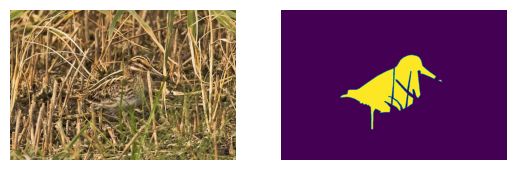

In [15]:
random_idx = random.randint(0,len(train_img_list))
sample_img = train_img_list[random_idx]
sample_gt = train_gt_list[random_idx]
#sample_gt = train_gt_path/f"{sample_img.name[:len(sample_img.name)-3]}png"
(sample_img, sample_gt)

img = Image.open(sample_img)
gt = Image.open(sample_gt)

print(f"Random index = {random_idx}, Image size_HxW = {tuple(reversed(img.size))}")

plt.subplot(1,2,1)
plt.imshow(np.asarray(img))
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(np.asarray(gt))
plt.axis(False)

### 1.2 Dataset

In [16]:
#from datasets import Dataset, Image, load_dataset
from transformers import SamProcessor

In [17]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [40]:
class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item    = self.dataset[idx]
        image   = Image.open(item["image"])
        gtmask  = Image.open(item["gtmask"])
        
        # get the bounding box prompt
        bbox_prompt = get_bounding_box(np.array(gtmask))
        
        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[bbox_prompt]], return_tensors="pt")
        
        # remove batch dimension which the processor adds by default
        inputs = {key:value.squeeze(0) for key,value in inputs.items()}
        
        # add ground truth mask
        inputs["ground_truth_mask"] = np.array(gtmask)
        
        return inputs


In [41]:
cod10k_train = []
for idx in range(len(train_img_list)):
    item = {"image":train_img_list[idx],
            "gtmask":train_gt_list[idx]}
    cod10k_train.append(item)

processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

train_dataset = SAMDataset(dataset = cod10k_train,
                          processor= processor)


In [51]:
for k,v in train_dataset[1].items():
    print(k,v.shape)

train_dataset[0]['original_sizes'], train_dataset[0]['reshaped_input_sizes'], train_dataset[0]['input_boxes']

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (533, 800)


(tensor([600, 800]),
 tensor([ 768, 1024]),
 tensor([[135.6800, 252.1600, 864.0000, 582.4000]], dtype=torch.float64))

### 1.3 Data Loader

In [43]:
from torch.utils.data import DataLoader

In [50]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [49]:
batch = next(iter(train_dataloader))

RuntimeError: stack expects each tensor to be equal size, but got [528, 1023] at entry 0 and [665, 972] at entry 1

## 2. Model

### 2.1 Preparing SAM(ViT-h) for Fine-tuning

In [47]:
sam_checkpoint_h = "/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth"
sam_h = sam_model_registry["vit_h"](checkpoint=sam_checkpoint_h)
sam_h.to(device)
print(f"Model device is {sam_h.device}")

Model device is cpu


In [48]:
# Freeze Image Encoder and Prompt Encoder
for param in sam_h.image_encoder.parameters():
    param.requires_grad = False

for param in sam_h.prompt_encoder.parameters():
    param.requires_grad = False

In [49]:
summary(model=sam_h, col_names=['num_params','trainable'])

Layer (type:depth-idx)                             Param #                   Trainable
Sam                                                --                        Partial
├─ImageEncoderViT: 1-1                             5,242,880                 False
│    └─PatchEmbed: 2-1                             --                        False
│    │    └─Conv2d: 3-1                            (984,320)                 False
│    └─ModuleList: 2-2                             --                        False
│    │    └─Block: 3-2                             (19,681,760)              False
│    │    └─Block: 3-3                             (19,681,760)              False
│    │    └─Block: 3-4                             (19,681,760)              False
│    │    └─Block: 3-5                             (19,681,760)              False
│    │    └─Block: 3-6                             (19,681,760)              False
│    │    └─Block: 3-7                             (19,681,760)              Fals

### 2.1 Preparing Dataloaders

In [50]:
#image_transform = transforms.Compose([transforms.Resize((1024,1024)), transforms.ToTensor()])
'''
train_dataset = CamouflageDataset(
    root_dir="/kaggle/input/cod10k/COD10K-v2",
    split="train",
    sam_model=sam_h
)

test_dataset = CamouflageDataset(
    root_dir="/kaggle/input/cod10k/COD10K-v2",
    split="test",
    sam_model=sam_h
)
'''

In [51]:
#train_dataloader = DataLoader(train_dataset,batch_size=2, shuffle=True)
#test_dataloader = DataLoader(test_dataset,batch_size=2, shuffle=False)

In [52]:
#input_image, gt = next(iter(train_dataloader))

img: (<class 'PIL.JpegImagePlugin.JpegImageFile'>, (800, 572))
gt: (<class 'PIL.PngImagePlugin.PngImageFile'>, (800, 572))
img_np: (<class 'numpy.ndarray'>, (572, 800, 3))
gt_np: (<class 'numpy.ndarray'>, (572, 800))
img_transformed: (<class 'numpy.ndarray'>, (732, 1024, 3))
gt_transformed: (<class 'numpy.ndarray'>, (732, 1024))
img_tensor: (<class 'torch.Tensor'>, torch.Size([3, 732, 1024]), torch.uint8)
gt_tensor: (<class 'torch.Tensor'>, torch.Size([732, 1024]), torch.uint8)
img_preprocessed: (<class 'torch.Tensor'>, torch.Size([3, 1024, 1024]), torch.float32)
gt_preprocessed: (<class 'torch.Tensor'>, torch.Size([1, 1024, 1024]), torch.float32)
img: (<class 'PIL.JpegImagePlugin.JpegImageFile'>, (768, 1024))
gt: (<class 'PIL.PngImagePlugin.PngImageFile'>, (768, 1024))
img_np: (<class 'numpy.ndarray'>, (1024, 768, 3))
gt_np: (<class 'numpy.ndarray'>, (1024, 768))
img_transformed: (<class 'numpy.ndarray'>, (1024, 768, 3))
gt_transformed: (<class 'numpy.ndarray'>, (1024, 768))
img_tenso

In [53]:
#input_image.shape, gt.shape, input_image.dtype, gt.dtype

(torch.Size([2, 3, 1024, 1024]),
 torch.Size([2, 1, 1024, 1024]),
 torch.float32,
 torch.float32)

In [55]:
'''with torch.no_grad():
    image_embedding = sam_h.image_encoder(input_image)
    sparse_embeddings, dense_embeddings = sam_h.prompt_encoder(
        points=None,
        boxes=None,
        masks=None,
    )

low_res_masks, iou_predictions = sam_h.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam_h.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False
)
masks = F.interpolate(
    low_res_masks,
    (sam_h.image_encoder.img_size, sam_h.image_encoder.img_size),
    mode="bilinear",
    align_corners=False
)'''

'with torch.no_grad():\n    image_embedding = sam_h.image_encoder(input_image)\n    sparse_embeddings, dense_embeddings = sam_h.prompt_encoder(\n        points=None,\n        boxes=None,\n        masks=None,\n    )\n\nlow_res_masks, iou_predictions = sam_h.mask_decoder(\n    image_embeddings=image_embedding,\n    image_pe=sam_h.prompt_encoder.get_dense_pe(),\n    sparse_prompt_embeddings=sparse_embeddings,\n    dense_prompt_embeddings=dense_embeddings,\n    multimask_output=False\n)\nmasks = F.interpolate(\n    low_res_masks,\n    (sam_h.image_encoder.img_size, sam_h.image_encoder.img_size),\n    mode="bilinear",\n    align_corners=False\n)'

In [ ]:
masks.shape, gt.shape, masks.dtype, gt.dtype

In [ ]:
m = masks[1].to("cpu").squeeze()
tx = transforms.ToPILImage()
m_img = tx(m)
type(m_img),m_img.size

In [ ]:
#for i in range(train_dataloader.batch_size):
plt.subplot(1,1,1)
plt.imshow(m_img)

In [ ]:
loss_fn = BCELoss()
loss = loss_fn(masks, gt)

In [ ]:
loss.dtype

## 3. Training

### 3.1 Utility Functions for Training Loop

In [ ]:
def prep_batched_input(img_dict, gt):
    """
    Prepares a List(Dict) over images in the format suitable for SAM.
    
    Arguments: img_dict (dict[str:list]): A dict with following key-value pairs
                    'image'        : (list(torch.Tensor)) A list of images in the batch
                    'original_size': (list(torch.Tensor, torch.Tensor)) both the tensors of size B
                                     A list of image sizes from dataloader. [H's, W's] (=1024x1024)
                    'raw_size'     : (list(torch.Tensor, torch.Tensor)) both the tensors of size B
                                     A list of image sizes from cod10k. [H's, W's]
                gt (torch.Tensor): Batch of ground truths from dataloader (Bx1XHxW)
    Returns: batched_input (list[dict[str:__]]): A list over images, each a dict with following keys
                'image'        : (torch.Tensor) An image as a torch tensor in 3xHxW shape (=3x1024x1024),
                'original_size': (tuple(torch.Tensor, torch.Tensor)) The size from dataloader(H,W)(=1024x1024)
                'raw_size'     : (tuple(torch.Tensor, torch.Tensor)) The size from cod10k(H,W)
    """
    batch_size = len(gt)
    batched_input = []
    for i in range(batch_size):
        #print(i)
        img_dict_new = {'image': img_dict['image'][i],
                        'original_size': (img_dict['original_size'][0][i],img_dict['original_size'][1][i]),
                        'raw_size': (img_dict['raw_size'][0][i],img_dict['raw_size'][1][i])
                        #'point_coords': ,
                        #'point_labels': ,
                        #'boxes': ,
                        #'mask_inputs': 
                       }
        #print(f"before append: {len(batched_input)}")
        batched_input.append(img_dict_new)
        #print(f"after append: {len(batched_input)}")
    return batched_input

In [ ]:
def assert_mask_dims(batched_input, masks):
    for i in range(len(masks)):
        assert len(masks)==len(batched_input),"Length of 'masks' and 'batched_input' doesn't match!"
        assert batched_input[i]['raw_size'] == masks[0]['masks'].shape[-2:], "mask size mismatch @ index {i}"

In [ ]:
def resize_to_actual_size(batched_input, masks, gts):
    """
    Resizes the predicted masks and ground truths to actual sizes using raw_size from batched_input.
    
    Arguments: batched_input (list[dict[str:__]]): A list over images, each a dict with following keys
                 'image'        : (torch.Tensor) An image as a torch tensor in 3xHxW shape (=3x1024x1024),
                 'original_size': (tuple(torch.Tensor, torch.Tensor)) The size from dataloader(H,W)(=1024x1024)
                 'raw_size'     : (tuple(torch.Tensor, torch.Tensor)) The size from cod10k(H,W)
                masks (list(dict[str:__])) : masks from the output of SAM
                gts
                
    """
    assert len((masks))
    final_masks = []
    final_gts = []
    for i in range(len(masks)):
        final_mask = {
            'masks': transforms.Resize(batched_input[i]['raw_size'])(masks[i]['masks']).squeeze(dim=0),
            'iou_predictions': masks[i]['iou_predictions'],
            'low_res_logits': masks[i]['low_res_logits']
        }
        final_gt = transforms.Resize(batched_input[i]['raw_size'])(gts[i])
        final_masks.append(final_mask)
        final_gts.append(final_gt)
    return final_masks, final_gts
    

### 3.2 Loss and Optimizer

In [ ]:
a = transforms.Resize((500,500))(gt[0])

In [ ]:
len(masks), len(gt)

In [ ]:
final_masks[0]['masks'].shape, final_masks[1]['masks'].shape, final_masks[2]['masks'].shape

In [ ]:
img_dict,gt = next(iter(train_dataloader))
batched_input = prep_batched_input(img_dict, gt)
masks = sam_h(batched_input=batched_input, multimask_output=False)
final_masks, final_gts = resize_to_actual_size(batched_input=batched_input, masks=masks, gts=gt)

In [ ]:
final_gts[2].shape, final_masks[2]['masks'].shape

In [ ]:
masks

In [ ]:
batched_input[]['image']

In [ ]:
final_gts[0].shape, final_gts[1].shape, final_gts[2].shape

In [ ]:
x = final_masks[0]['masks'].bool()

In [ ]:
type(gt)

In [ ]:
gt[0].shape, x.shape

In [ ]:
loss_fn = nn.BCELoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=sam_h.parameters(), lr=0.1)

In [ ]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)
#output.backward()

In [ ]:
x = m(input)

In [ ]:
x.shape